In [4]:
!jupyter nbconvert --to script pack_existing_segs.ipynb

[NbConvertApp] Converting notebook pack_existing_segs.ipynb to script
[NbConvertApp] Writing 1722 bytes to pack_existing_segs.py


In [5]:
import uuid
from pack_existing_segs import *
from tianshou.utils import WandbLogger, LazyLogger
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import logging
import pickle
from enum import Enum
from IPython import display
from pack_existing_segs import unpack_new_seg_out
import utils as ut
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
import gc
from torchvision.models import resnet50
import numpy as np
from torchvision import transforms
import os
import glob
from PIL import Image
import PIL
import json
from pathlib import Path
import tianshou as ts
from gymnasium.wrappers import TimeLimit
import einops
from transformers import ViTImageProcessor, ViTModel
from customs import custom_offpolicy_trainer, CustomDQNPolicy, CustomOffpolicyTrainer
import time
from dataset import *
from env import *
from networks.q_network import Q_network
%matplotlib inline

In [6]:
# if username is server use cuda
if os.environ['USER'] == 'server':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# if __name__ == '__main__':
#     torch.multiprocessing.set_start_method('spawn')

In [7]:
def get_train_fn(policy, eps_train, inital_phase):
    def train_fn(epoch, env_step):
        policy.set_eps(eps_train[epoch - 1])
        if epoch >= inital_phase:
            for param in policy.model.vit.parameters():
                param.requires_grad = True

        if epoch >= 0 and epoch % 50 == 0:
            torch.save(policy.state_dict(), f'saved/policy_{wandb_logger.wandb_run.name if use_wandb else uuid.uuid4().hex}.pt')

        wandb_logger.write('train', trainer.env_step, {"epoch": epoch})
    return train_fn

In [8]:
def register_hooks(model):
    hook0 = model.dueling_head.Q.model[-1].register_forward_hook(lambda self, input, output: print(f"Q: {output}"))
    hook1 = model.dueling_head.V.model[-1].register_forward_hook(lambda self, input, output: print(f"V: {output}"))
    # hook2 = model.dueling_head.model.model[0].register_forward_hook(lambda self, input, output: print(f"net: {output}"))


In [9]:
if __name__ == "__main__":
    # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
    lr, epoch, batch_size = 8e-5, 2000, 20
    initial_phase = 0
    test_num = 10
    gamma, n_step, target_freq = 0.98, 1, 1200
    buffer_size = 20000
    eps_start, eps_end = 0.9, 0.05
    eps_train, eps_test = np.linspace(eps_start, eps_end, epoch), 0
    step_per_epoch, step_per_collect = 2000, 100
    env_step_limit = step_per_collect

    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    # train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataset), 100) for _ in range(1)])
    train_envs = ts.env.DummyVectorEnv([lambda: TimeLimit(Environment(dataset, (32, 32)), env_step_limit) for _ in range(1)])
    # test_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataset), 100) for _ in range(1)])
    action_count = train_envs.get_env_attr('action_space', 0)[0].n
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    # policy = ts.policy.DQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq)
    policy = CustomDQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq, polyak=None)
    # register_hooks(policy.model)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['embeddings.mask_token', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
policy.load_state_dict(torch.load('saved/policy_whole-durian-46.pt'))

<All keys matched successfully>

In [ ]:
if __name__ == "__main__":
    replay_buffer = ts.data.VectorReplayBuffer(buffer_size, len(train_envs))
    train_collector = ts.data.Collector(policy, train_envs, replay_buffer, exploration_noise=True)
    # test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)

    use_wandb = False
    if use_wandb:
        wandb_logger = WandbLogger(
            train_interval=1,
            test_interval=1,
            update_interval=1,
            project="AttentionRL",
        )
        wandb_logger.load(SummaryWriter("./logs"))

        wandb_logger.wandb_run.config['lr'] = lr
        wandb_logger.wandb_run.config['epoch'] = epoch
        wandb_logger.wandb_run.config['batch_size'] = batch_size
        wandb_logger.wandb_run.config['initial_phase'] = initial_phase
        wandb_logger.wandb_run.config['test_num'] = test_num
        wandb_logger.wandb_run.config['gamma'] = gamma
        wandb_logger.wandb_run.config['n_step'] = n_step
        wandb_logger.wandb_run.config['target_freq'] = target_freq
        wandb_logger.wandb_run.config['buffer_size'] = buffer_size
        wandb_logger.wandb_run.config['eps_start'] = eps_start
        wandb_logger.wandb_run.config['eps_end'] = eps_end
        wandb_logger.wandb_run.config['step_per_epoch'] = step_per_epoch
        wandb_logger.wandb_run.config['step_per_collect'] = step_per_collect
        wandb_logger.wandb_run.config['env_step_limit'] = env_step_limit
    else:
        wandb_logger = LazyLogger()


    trainer = CustomOffpolicyTrainer(
        policy=policy, train_collector=train_collector, test_collector=None, episode_per_test=test_num, max_epoch=epoch,
        step_per_epoch=step_per_epoch, step_per_collect=step_per_collect,
        batch_size=batch_size, update_per_step=1 / step_per_collect * 4,
        train_fn=get_train_fn(policy, eps_train, initial_phase),
        test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
        stop_fn=lambda mean_rewards: mean_rewards >= 0,
        logger= wandb_logger,
    )
    trainer.run()

In [ ]:
# if __name__ == "__main__":
#     env = TimeLimit(Environment(dataset, (32, 32)), 200)
#     ut.show_masks_on_image(einops.rearrange(env.current_image, 'c h w -> h w c'), env.current_seg.cpu().numpy())
#     plt.show()

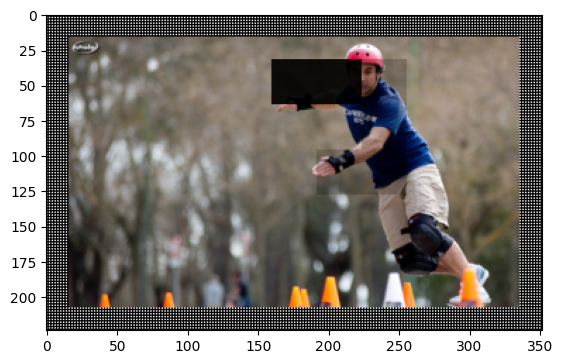

KeyboardInterrupt: 

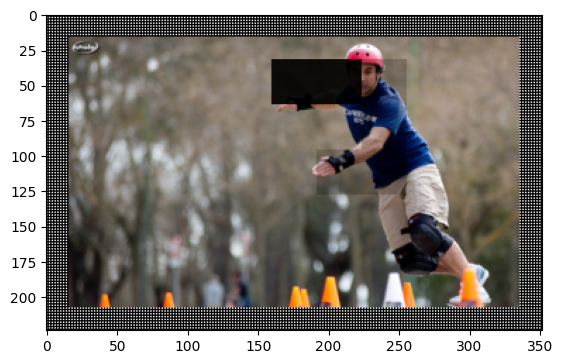

In [11]:
if __name__ == "__main__":
    # dataset = COCODataset(root="../Data/COCO17", train=True, len=1)
    policy.eval()
    policy.set_eps(eps_test)
    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    env = TimeLimit(Environment(dataset, (32, 32)), 100)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=1, render=1/10)
    # collector.collect(n_episode=1)